# Experimento 2: _One Vs All_

Realizando classificação com KNN usando para treino os arquivos `chbNN_com_dwt.csv` onde `NN` pertence ao `chb_set`, com exceção do que será usado para teste.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier

# Carregando intervalo de chb
file_range = [
    '01', '02', '03', '04', '05', '07', '08',
    '10', '11', '12', '13', '14', '15', '16',
    '17', '18', '19', '21', '22', '23', '24'
]

def dataframe_from_chb(chb_number:str):
    df = pd.read_csv(f'./chb{chb_number}/chb{chb_number}_com_dwt.csv')
    df['chb'] = chb_number
    return df

chb_df = pd.concat([dataframe_from_chb(file) for file in file_range], ignore_index=True)


some_6_channels = ['2', '3', '6', '7', '10', '14']
some_8_channels = some_6_channels + ['5', '11']

# Filtrando colunas do chb que são referentes aos canais em some_6_channels
columns_from_6_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_6_channels]

# Filtrando colunas do chb que são referentes aos canais em some_8_channels
columns_from_8_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_8_channels]

In [2]:
acc_df_list = []

proba_dict = {
    file:{
        channel:pd.DataFrame() for channel in ['all', '6ch', '8ch']
    } for file in file_range
}

for file in file_range:

    # Separando dados de treino e teste
    chb_copy_df = chb_df.copy()

    chb_train = chb_copy_df.query('chb != @file')
    chb_test = chb_copy_df.query('chb == @file')

    chb_train.pop('chb')
    chb_test.pop('chb')

    y_train = chb_train.pop('target').values
    y_test = chb_test.pop('target').values

    # Para 20 rodadas com todos os canais
    X_all = chb_train.values

    # Para 20 rodadas com os 6 canais
    X_6_channels = chb_train[columns_from_6_channels].values

    # Para 20 rodadas com os 8 canais
    X_8_channels = chb_train[columns_from_8_channels].values

    # Instanciando e treinando classificadores
    model_all = KNeighborsClassifier().fit(X_all, y_train)
    model_6_ch = KNeighborsClassifier().fit(X_6_channels, y_train)
    model_8_ch = KNeighborsClassifier().fit(X_8_channels, y_train)

    # gerando probabilidades
    proba_all = model_all.predict_proba(chb_test.values)
    proba_6ch = model_6_ch.predict_proba(chb_test[columns_from_6_channels].values)
    proba_8ch = model_8_ch.predict_proba(chb_test[columns_from_8_channels].values)

    # Salvando probabilidades em dicionário
    for channel, proba_arr in zip(['all', '6ch', '8ch'], [proba_all, proba_6ch, proba_8ch]):
        for num, classification in enumerate(['negative', 'positive']):
            df = proba_dict[file][channel]
            df[f'{classification} sample-negative proba'], df[f'{classification} sample-positive proba'] = np.array([proba for proba, target in zip(proba_arr, y_test) if target == num]).transpose()

    # Formando dataframe de acurácias
    acc_df = pd.DataFrame(data=[file], columns=['chb'], dtype=np.float64)
    acc_df['all channels'] = model_all.score(chb_test.values, y_test)
    acc_df['2_3_6_7_10_14 channels'] = model_6_ch.score(chb_test[columns_from_6_channels].values, y_test)
    acc_df['2_3_6_7_10_14_11_14 channels'] = model_8_ch.score(chb_test[columns_from_8_channels].values, y_test)

    acc_df_list.append(acc_df)

one_vs_all_df = pd.concat(acc_df_list, ignore_index=True).sort_values(by='chb')
one_vs_all_df.to_csv('./oneVSall.csv', index=False)

## Metricas

In [3]:
one_vs_all_df = pd.read_csv('./oneVSall.csv')
one_vs_all_df.style.background_gradient(cmap='Blues', subset=one_vs_all_df.columns[1:]).hide_index()

chb,all channels,2_3_6_7_10_14 channels,2_3_6_7_10_14_11_14 channels
1.000000,0.905093,0.870370,0.893519
2.000000,0.767857,0.863095,0.821429
3.000000,0.938776,0.905612,0.913265
4.000000,0.801075,0.768817,0.733871
5.000000,0.880000,0.898182,0.878182
7.000000,0.950000,0.943750,0.943750
8.000000,0.772527,0.719780,0.772527
10.000000,0.922018,0.880734,0.908257
11.000000,0.756250,0.836250,0.836250
12.000000,0.589286,0.608193,0.608193


In [4]:
one_vs_all_df.style.background_gradient(cmap='Blues', subset=one_vs_all_df.columns[1:], axis='columns').hide_index()

chb,all channels,2_3_6_7_10_14 channels,2_3_6_7_10_14_11_14 channels
1.000000,0.905093,0.870370,0.893519
2.000000,0.767857,0.863095,0.821429
3.000000,0.938776,0.905612,0.913265
4.000000,0.801075,0.768817,0.733871
5.000000,0.880000,0.898182,0.878182
7.000000,0.950000,0.943750,0.943750
8.000000,0.772527,0.719780,0.772527
10.000000,0.922018,0.880734,0.908257
11.000000,0.756250,0.836250,0.836250
12.000000,0.589286,0.608193,0.608193


## Descrição geral

,all channels,2_3_6_7_10_14 channels,2_3_6_7_10_14_11_14 channels
count,21.000000,21.000000,21.000000
mean,0.767114,0.754170,0.756905
std,0.174430,0.189417,0.187686
min,0.367647,0.308824,0.338235
25%,0.750000,0.709150,0.627451
50%,0.786458,0.836250,0.821429
75%,0.905172,0.880734,0.893519
max,0.950000,0.943750,0.944444


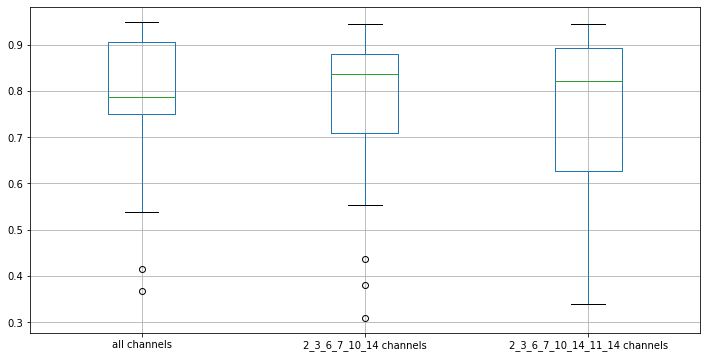

In [5]:
one_vs_all_df[one_vs_all_df.columns[1:]].boxplot(figsize=(12, 6))
one_vs_all_df[one_vs_all_df.columns[1:]].describe()

## Descrição excluindo os dois piores chb

,all channels,2_3_6_7_10_14 channels,2_3_6_7_10_14_11_14 channels
count,19.000000,19.000000,19.000000
mean,0.806662,0.797331,0.800450
std,0.128099,0.138131,0.134615
min,0.538462,0.435897,0.493590
25%,0.762054,0.736626,0.753199
50%,0.801075,0.863095,0.836250
75%,0.905485,0.888435,0.900888
max,0.950000,0.943750,0.944444


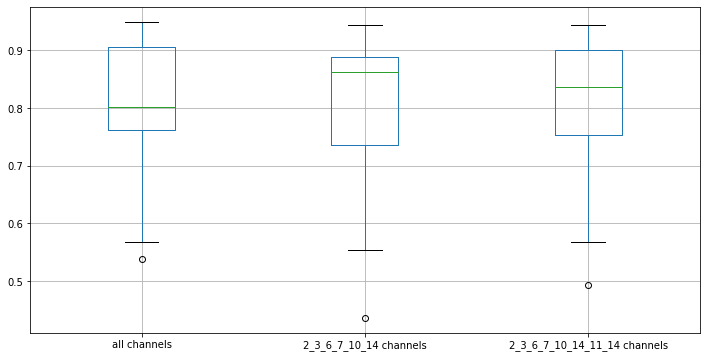

In [6]:
one_vs_all_df.sort_values(by='all channels', ascending=False).head(19)[one_vs_all_df.columns[1:]].boxplot(figsize=(12, 6))
one_vs_all_df.sort_values(by='all channels', ascending=False).head(19)[one_vs_all_df.columns[1:]].describe()

# Observando margem de probabilidade do canal 22 para todos os canais

,negative sample-negative proba,negative sample-positive proba,positive sample-negative proba,positive sample-positive proba
count,99.000000,99.000000,99.000000,99.000000
mean,0.935354,0.064646,0.103030,0.896970
std,0.163703,0.163703,0.200741,0.200741
min,0.200000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.800000
50%,1.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.200000,1.000000
max,1.000000,0.800000,1.000000,1.000000


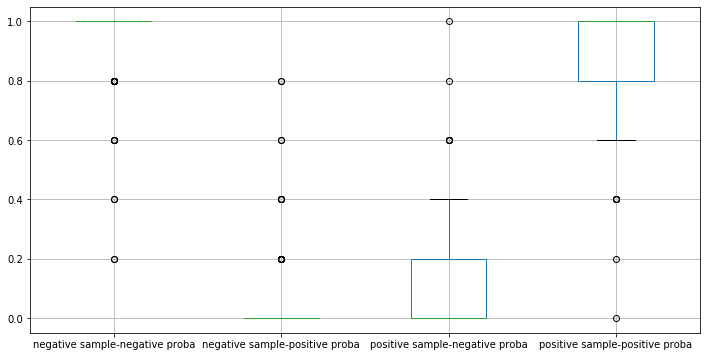

In [7]:
proba_22_all_df = proba_dict['22']['all']

proba_22_all_df.boxplot(figsize=(12, 6))
proba_22_all_df.describe()

In [8]:
proba_22_all_df

,negative sample-negative proba,negative sample-positive proba,positive sample-negative proba,positive sample-positive proba
0,1.0,0.0,0.4,0.6
1,1.0,0.0,0.0,1.0
2,0.6,0.4,0.0,1.0
3,1.0,0.0,0.2,0.8
4,1.0,0.0,0.0,1.0
...,...,...,...,...
94,1.0,0.0,0.2,0.8
95,1.0,0.0,0.4,0.6
96,1.0,0.0,0.0,1.0
97,1.0,0.0,0.4,0.6
